# Projet 8 : Réalisez un dashboard et assurez une veille technique

## <a name="C0"> Contexte 2 - Assurer une veille technologique<a>

### Problématique :
- Je suis Data Scientist au sein d'une société financière nommée Prêt à dépenser, qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
- Je viens de mettre en œuvre un outil de "scoring crédit" pour calculer la probabilité qu'un client rembourse son crédit, et classifier la demande en crédit accordé ou refusé. 
    
Après avoir bien avancé dans la réalisation du dashboard, Michaël décide de me confier une autre mission.

    
**Mission :** Réaliser un état de l'art sur une technique récente de modélisation de données texte ou de données image, l'analyser, la tester et la comparer à une approche plus classique que j'ai réalisée précédemment. 
    
Concrètement, voici ce que je dois effectuer :
- L'état de l’art devra concerner une technique datant de moins de 5 ans, présentée dans un article.
- La technique doit être référencée sur des sites de recherche (Arxiv), des sites connus (par exemple fastml, machine learning mastery, kdnuggets,  import AI, MIT tech review, MIT news ML) ou des newsletters de qualité comme data elixir et data science weekly. 
- Je dois réaliser et présenter une preuve de concept qui met en oeuvre cette nouvelle technique avec les données texte ou image que j'ai déjà  exploitées précédemment.
- Je dois expliquer rapidement les concepts et techniques dans une note méthodologique et lors d'une présentation.

**Approche choisie :**
> Je reprends le projet "Classifiez automatiquement des biens de consommation" afin de réaliser cette mission. L'état de l'art sera réalisée sur l'approche DeBERTa (Decoding-enhanced BERT with Disentangled Attention) en comparaison avec l'approche BERT.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix
import seaborn as sns
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score,adjusted_rand_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,MiniBatchKMeans

from collections import Counter
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.probability import FreqDist

from transformers import BertTokenizer,BertModel,DebertaTokenizer,DebertaV2Tokenizer,DebertaModel,AutoTokenizer,AutoModel
import torch
import tensorflow as tf
import tensorflow_hub as hub
import gensim
from gensim.models import Word2Vec

import shap
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

from unidecode import unidecode
import re
import string
from wordcloud import WordCloud, STOPWORDS
import IPython
import random
import os
os.environ["OMP_NUM_THREADS"] = "5"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# I. Exploration des données textuelles

In [2]:
# Import  data
text_data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv') 
text_data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [3]:
# Data info
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

**Déplication des étiquettes de la colonne « product_category_tree »**

In [4]:
# Splitting sub-categories into new columns
classes = text_data["product_category_tree"].str.split(" >> ", expand=True)

# Get the distribution of each level of category
for classe in classes.columns :
    print(f"Voici le niveau {classe} des catégories de produits :")
    display(classes.groupby([classe]).size())
    print("\n")

Voici le niveau 0 des catégories de produits :


0
["Baby Care                     150
["Beauty and Personal Care      150
["Computers                     150
["Home Decor & Festive Needs    150
["Home Furnishing               150
["Kitchen & Dining              150
["Watches                       150
dtype: int64



Voici le niveau 1 des catégories de produits :


1
Baby & Kids Gifts        15
Baby Bath & Skin         14
Baby Bedding             15
Baby Grooming             4
Bar & Glassware           8
                       ... 
Tableware & Cutlery       3
Tidy Home Furnishing      1
Wall Decor & Clocks      22
Women's Hygiene           1
Wrist Watches           149
Length: 63, dtype: int64



Voici le niveau 2 des catégories de produits :


2
AKUP Coffee Mugs                         5
AM Creation Coffee Mugs                  1
Aapno Rajasthan Showpieces"]             2
Adaa Showpieces"]                        1
Adapters                                 9
                                        ..
brass gift center Religion & Devotion    1
eCraftIndia Showpieces"]                 1
fastrack Wrist Watches"]                 1
palito Wrist Watches                     3
posterchacha Coffee Mugs                 1
Length: 246, dtype: int64



Voici le niveau 3 des catégories de produits :


3
3kFactory Baby Shower Caps                               1
4D Batteries"]                                           1
999store Stickers"]                                      1
99Gems USB Gadgets"]                                     1
@home Flower Vase                                        2
                                                        ..
palito PLO 149 Analog Watch  - For Girls, Women"]        1
palito PLO 166 Analog Watch  - For Girls, Women"]        1
palito PLO 169 Analog Watch  - For Girls, Women"]        1
posterchacha Ishita Personalised Custom Name Hap..."]    1
wallskart Wallpapers                                     1
Length: 350, dtype: int64



Voici le niveau 4 des catégories de produits :


4
3kFactory Baby Shower Cap- Purple"]                      1
612 League Shirts                                        1
@home Earthy Wine Net Ceramic Vase (9.8250000000..."]    1
@home Glass Vase (18 inch, Grey)"]                       1
APOLLO+ Pack Of 3 Flexible Led Light (Multicolour)"]     1
                                                        ..
oxford Pans & Tawas                                      1
painting_art_couple_love__Dance Paper Print (12 ..."]    1
scarlet tanager bird normal POSTER Paper Print (..."]    1
vatika Idli Makers                                       1
wallskart Floral & Botanical Wallpaper (35.56 cm..."]    1
Length: 297, dtype: int64



Voici le niveau 5 des catégories de produits :


5
612 League Baby Boy's Checkered Casual Shirt"]           1
Aarika Salwar Kurta Dupattas                             1
Al Fakher Hookah Flavors"]                               1
Anthill Bodysuits"]                                      1
AntiqueShop ABKL_GRN_GRN_GRN"]                           1
                                                        ..
florence9 Caps                                           1
kawal fashion Pyjama Baby Girl's  Combo"]                1
next steps Night Suits                                   1
oxford Tawa 15 cm cm diameter (Aluminium, Non-st..."]    1
vatika Advance Standard Idli Maker (7 Plates , 1..."]    1
Length: 117, dtype: int64



Voici le niveau 6 des catégories de produits :


6
Aarika Self Design Kurta & Patiyala"]                    1
Babeezworld Baby Boy's Romper"]                          1
Baby Moshai Baby Girl's A-line Dress"]                   1
Beebay Baby Girl's Fit and Flare Dress"]                 1
Budding Bees Printed Baby Girl's Jumpsuit"]              1
CHOCOBERRY Baby Girl's Printed White, Dark Blue ..."]    1
Chokree Baby Girl's A-line Dress"]                       1
Chokree Baby Girl's, Girl's A-line Dress"]               1
CoffeeBean Regular Fit Baby Girl's Pink Trousers"]       1
Esteem Baby Boy's Drawer"]                               1
FS Mini Klub Baby Boy's Bodysuit"]                       1
FS Mini Klub Baby Boy's Sleepsuit"]                      1
FS Mini Klub Baby Girl's Bodysuit"]                      1
FS Mini Klub Printed Baby Boy's Multicolor Basic..."]    1
Fs Mini Klub Baby Girl's Fit and Flare Dress"]           1
Jacadi Paris Baby Girl's Gathered Blue Dress"]           1
Jacadi Paris Baby Girl's Gathered Dark Blue Dress"]   

- Nous avons $7$ niveaux de catégories dans la colonne "product_category_tree". Le premier niveau nous donne une catégorisation équilibrée des produits avec $150$ éléments pour chaque label.
- Nous allons nous limiter à ce premier niveau de catégorie des produits dans la suite.

In [5]:
# Separate the levels of categories
text_data["labels"] = classes[0] 

# Cleaning the [" in our labels
text_data = text_data.replace('\\["', '', regex=True)
# Keeping only the description and the label of products
text_data = text_data[["description","labels"]]
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  1050 non-null   object
 1   labels       1050 non-null   object
dtypes: object(2)
memory usage: 16.5+ KB


**Représentation de la distribution des catégories.**

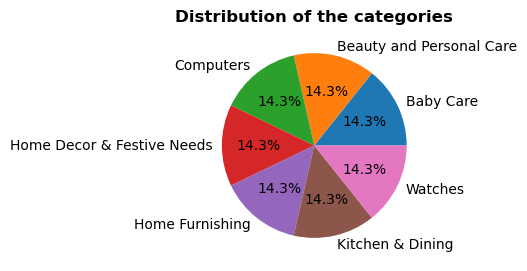

In [6]:
# Plot pie chart
plt.figure(figsize=(5,3))
plt.pie(text_data.groupby(["labels"]).size(),labels=text_data.groupby(["labels"]).size().index,autopct='%1.1f%%')
plt.title(f"Distribution of the categories",fontweight="bold")
plt.show()

**Nettoyage**

In [7]:
def text_cleaning(text):
    """
    Lowercase text, remove text in square brackets, links, punctuation, numbers, etc.
    """
    text = re.sub(r'\[.*?\]', '', text)  # Supprime le texte entre crochets []
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Supprime les URLs
    text = re.sub(r'<.*?>+', '', text)  # Supprime les balises HTML
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Supprime la ponctuation
    text = re.sub(r'\n', ' ', text)  # Remplace les sauts de ligne par des espaces
    text = re.sub(r'\w*\d\w*', '', text)  # Supprime les mots contenant des chiffres
    text = text.lower()  # Convertit en minuscules
    return text

# Applying the cleaning function to the dataset
text_data["description_cleaned"] = text_data["description"].apply(lambda x: text_cleaning(x))
text_data["description_cleaned"].head()

0    key features of elegance polyester multicolor ...
1    specifications of sathiyas cotton bath towel  ...
2    key features of eurospa cotton terry face towe...
3    key features of santosh royal fashion cotton p...
4    key features of jaipur print cotton floral kin...
Name: description_cleaned, dtype: object

**Tokénisation des descriptions :**

La tokénization est un procédé très simple qui divise une chaîne de caractère en tokens, c'est-à-dire des éléments atomiques de la chaîne. Un token n'est pas forcément un mot, ce peut être par exemple une ponctuation. 

In [8]:
# Tokenization 
tokenizer = RegexpTokenizer(r'\w+')
text_data["description_tokenized"] = text_data["description_cleaned"].apply(lambda x:tokenizer.tokenize(x))
text_data["description_tokenized"].head()

0    [key, features, of, elegance, polyester, multi...
1    [specifications, of, sathiyas, cotton, bath, t...
2    [key, features, of, eurospa, cotton, terry, fa...
3    [key, features, of, santosh, royal, fashion, c...
4    [key, features, of, jaipur, print, cotton, flo...
Name: description_tokenized, dtype: object

**Mots vides(Stop Words) :**

Les stopwords dans un texte représentent tous les mots qui n'ont que peu d'intérêt sémantique et qui n'aident pas à distinguer un texte d'un autre. Ils sont en effet tous les mots les plus courants d'une langue (déterminants, pronoms, etc..).

In [9]:
# stopwords
nltk_stopwords = stopwords.words("english")

display("Number of nltk stopwords :",len(nltk_stopwords))

# list of nltk stopwords
display("list of nltk stopwords :",nltk_stopwords)

'Number of nltk stopwords :'

179

'list of nltk stopwords :'

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [10]:
# removing stopwords
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words("english")]
    return words 
text_data["description_tokenized"] = text_data["description_tokenized"].apply(lambda x : remove_stopwords(x))
text_data.head()

,description,labels,description_cleaned,description_tokenized
0,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,key features of elegance polyester multicolor ...,"[key, features, elegance, polyester, multicolo..."
1,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,specifications of sathiyas cotton bath towel ...,"[specifications, sathiyas, cotton, bath, towel..."
2,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,key features of eurospa cotton terry face towe...,"[key, features, eurospa, cotton, terry, face, ..."
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,key features of santosh royal fashion cotton p...,"[key, features, santosh, royal, fashion, cotto..."
4,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,key features of jaipur print cotton floral kin...,"[key, features, jaipur, print, cotton, floral,..."


**Lemmatisation des tokens :**

La lemmatisation permet de représenter sous un même mot plusieurs dérivées du mot. Elle laisse au mot un sens sémantique mais va éliminer le genre ou le pluriel par exemple.

In [11]:
# nltk.download('wordnet')

In [11]:
# lemmatization
lemmatizer = WordNetLemmatizer()
def lem_word(x):
    return [lemmatizer.lemmatize(w) for w in x]
text_data["description_tokenized"] = text_data["description_tokenized"].apply(lem_word)
text_data["description_tokenized"].head()

0    [key, feature, elegance, polyester, multicolor...
1    [specification, sathiyas, cotton, bath, towel,...
2    [key, feature, eurospa, cotton, terry, face, t...
3    [key, feature, santosh, royal, fashion, cotton...
4    [key, feature, jaipur, print, cotton, floral, ...
Name: description_tokenized, dtype: object

In [12]:
# My new corpus 
def rejoin_words(tokenized_column):    
    return (" ".join(tokenized_column))

text_data["processed_corpus"] = text_data.apply(lambda x: rejoin_words(x["description_tokenized"]), axis=1)
text_data["processed_corpus"].head()

0    key feature elegance polyester multicolor abst...
1    specification sathiyas cotton bath towel bath ...
2    key feature eurospa cotton terry face towel se...
3    key feature santosh royal fashion cotton print...
4    key feature jaipur print cotton floral king si...
Name: processed_corpus, dtype: object

In [13]:
text_data.head()

,description,labels,description_cleaned,description_tokenized,processed_corpus
0,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,key features of elegance polyester multicolor ...,"[key, feature, elegance, polyester, multicolor...",key feature elegance polyester multicolor abst...
1,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,specifications of sathiyas cotton bath towel ...,"[specification, sathiyas, cotton, bath, towel,...",specification sathiyas cotton bath towel bath ...
2,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,key features of eurospa cotton terry face towe...,"[key, feature, eurospa, cotton, terry, face, t...",key feature eurospa cotton terry face towel se...
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,key features of santosh royal fashion cotton p...,"[key, feature, santosh, royal, fashion, cotton...",key feature santosh royal fashion cotton print...
4,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,key features of jaipur print cotton floral kin...,"[key, feature, jaipur, print, cotton, floral, ...",key feature jaipur print cotton floral king si...


**La distribution des mots dans le corpus**

In [15]:
# Frequency of all words of all products in the description
corpus = ' '.join(text_data["processed_corpus"].tolist())
#print(corpus)
tokens = word_tokenize(corpus)
print(f"Le corpus nettoyé contient {len(tokens)} mots dont {len(set(tokens))} mots uniques.")              

Le corpus nettoyé contient 53700 mots dont 4840 mots uniques.


In [16]:
# Instanciate FreqDist 
fdist = FreqDist(tokens)
# Top 20 most frequent words
print(f"Les tokens les plus fréquents et leurs fréquences d'apparition :\n\n{fdist.most_common(20)}")   

Les tokens les plus fréquents et leurs fréquences d'apparition :

[('product', 861), ('free', 612), ('r', 594), ('buy', 581), ('delivery', 567), ('genuine', 564), ('shipping', 564), ('cash', 564), ('price', 559), ('replacement', 559), ('day', 552), ('cm', 539), ('flipkartcom', 472), ('guarantee', 471), ('mug', 449), ('feature', 403), ('online', 396), ('watch', 355), ('color', 354), ('type', 324)]


**Représentation graphique des mots les plus fréquents**

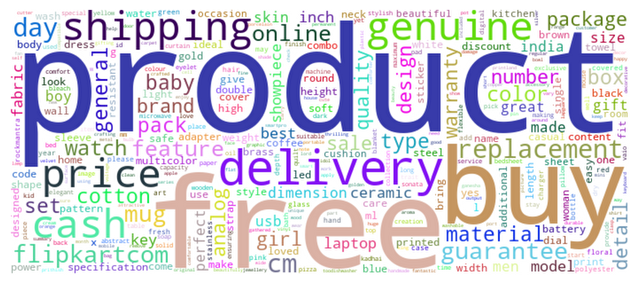

In [16]:
# Wordcloud of the corpora
def couleur(*args, **kwargs):
    return "rgb({}, {}, {})".format(random.randint(0, 250),random.randint(0, 250),random.randint(0, 250))
    
# Instanciate WordCloud
wordcloud = WordCloud(background_color="White", width=700,height=300,random_state=1,collocations=False, 
                     max_font_size=500, max_words=510).generate(corpus)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud.recolor(color_func = couleur),interpolation='bessel')
plt.axis("off")
plt.show()

# II. Vectorisation du corpus

- Je commence d'abord par numériser les labels de la colonne "labels" à l'aide de la méthode LabelEncoder de scikit-learn.

- L'incorporation de mots est une technique utilisée en traitement automatique du langage naturel(NLP) pour représenter des mots sous forme de vecteurs denses, ce qui permet aux mots ayant le même sens d'avoir des représentations similaires. L'idée est simple : les mots qui apparaissent dans les mêmes contextes ont tendance à avoir des significations similaires.

In [14]:
# Encoding the categories
label_encoder = LabelEncoder()
text_to_vectorize = text_data.copy()
text_to_vectorize["labels_encoded"] = label_encoder.fit_transform(np.array(text_to_vectorize["labels"]))
text_to_vectorize = text_to_vectorize[["processed_corpus","labels","labels_encoded"]]
text_to_vectorize.sample(10)

,processed_corpus,labels,labels_encoded
503,sonata watch buy sonata watch online india fli...,Watches,6
90,buy exotic india adi buddha vajrasattva showpi...,Home Decor & Festive Needs,3
963,specification loomkart blue polyester runner c...,Home Furnishing,4
861,buy kensington usb hub online kensington usb h...,Computers,2
1008,king trader kitchen tool set price r counted a...,Kitchen & Dining,5
548,timewel analog watch men buy timewel analog wa...,Watches,6
1012,ech oly ceramic inside fitting hookah mouth ti...,Home Decor & Festive Needs,3
468,key feature tks cotton hair towel size medium ...,Baby Care,0
579,timewel analog watch men buy timewel analog wa...,Watches,6
147,rockmantra fantasy ceramic mug l price r give ...,Kitchen & Dining,5


In [15]:
index_mat = label_encoder.inverse_transform([ 0, 1, 2, 3, 4, 5, 6])
index_mat

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [16]:
list_labels = text_to_vectorize.labels.unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [17]:
# Tsne according to real categories and according to clusters - ARI score
categories = list(text_to_vectorize.labels.unique())
def Tsne_2D(X,y_true,clusters) :
    # ARI score 
    ari_score = np.round(adjusted_rand_score(y_true, clusters),3)
    print(f"Le score ARI de mesure de similarité est de : {ari_score}")
    fig = plt.figure(figsize=(15,5),tight_layout=True)
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X[:,0],X[:,1],c=y_true,cmap="Set1") 
    ax.legend(handles=scatter.legend_elements()[0],labels=categories,bbox_to_anchor=(1,1),title="True classes")
    plt.title("Projection 2D with real categories",fontweight="bold")
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X[:,0],X[:,1],c=clusters, cmap="Set1")
    ax.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1),labels=set(clusters),title="Clusters")
    plt.title("Projection 2D with estimated clusters",fontweight="bold")
    
    plt.show()

## II.1. Approche Word2Vec

**Word2Vec :**

T. Mikolov et al. ont présenté Word2vec en 2013, qui apprend la signification des mots simplement en traitant un grand corpus de texte non étiqueté. L'approche Word2Vec utilise des réseaux neuronaux superficiels avec deux couches cachées, un sac de mots continu (CBOW) et le modèle Skip-gram pour créer un vecteur de grande dimension pour chaque mot. C'est cette nature non supervisée de Word2vec qui le rend assez puissant.

### II.1.a. Extraction des features

In [21]:
# Building and training Word2vec model
sentences = text_to_vectorize["processed_corpus"].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
word2vec_model = Word2Vec(sentences=sentences,vector_size=100,epochs=100,window=5)
word2vec_model.build_vocab(sentences)
word2vec_model_vectors = word2vec_model.wv
word2vec_vocabulary = word2vec_model_vectors.index_to_key

In [23]:
# Map text data to Word2Vec embeddings
def text_embedding(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in word2vec_model_vectors:
            vectors.append(word2vec_model_vectors[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)  # Return zeros if no word in vocabulary

initial_time = time.time()
X_word2vec = np.vstack(text_to_vectorize["processed_corpus"].apply(text_embedding))
duration_w2v=time.time()-initial_time
print("temps de Word2Vec : ", "%15.2f" % duration_w2v, "secondes")
X_word2vec

temps de Word2Vec :             0.11 secondes


array([[-0.1703118 , -0.40596414, -0.00921611, ...,  0.08672059,
         0.13049233, -0.48925385],
       [ 0.1135141 ,  0.17327803, -0.03759829, ...,  0.06603758,
        -0.5315612 , -0.27669019],
       [ 0.45953563,  0.14623506, -0.47971717, ..., -0.0197474 ,
         0.04021208, -0.37074563],
       ...,
       [-0.4770392 ,  0.5229436 , -0.08385619, ..., -0.29520723,
        -0.26553687,  0.3616386 ],
       [-0.237407  ,  0.87582743,  0.19810084, ...,  0.07171289,
        -0.20357072,  0.20701121],
       [-0.26002797,  0.60161346,  0.02958293, ...,  0.06215958,
        -0.19389562,  0.41135058]], dtype=float32)

In [24]:
X_word2vec = pd.DataFrame(X_word2vec)
X_word2vec_data = pd.concat([X_word2vec, text_to_vectorize], axis=1)
X_word2vec_data

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,processed_corpus,labels,labels_encoded
0,-0.170312,-0.405964,-0.009216,0.201870,0.378708,0.569134,1.273147,-0.028980,-0.345837,-0.559982,...,0.113352,0.422101,0.086061,0.719800,0.086721,0.130492,-0.489254,key feature elegance polyester multicolor abst...,Home Furnishing,4
1,0.113514,0.173278,-0.037598,-0.499087,0.707173,-0.149107,0.467524,-0.199746,0.083627,0.038577,...,0.496374,0.018115,-0.114308,-0.311347,0.066038,-0.531561,-0.276690,specification sathiyas cotton bath towel bath ...,Baby Care,0
2,0.459536,0.146235,-0.479717,-0.557082,0.066359,0.265645,0.471034,-0.402640,0.180043,-0.378972,...,0.747621,-0.438077,0.193408,-0.253944,-0.019747,0.040212,-0.370746,key feature eurospa cotton terry face towel se...,Baby Care,0
3,-0.050412,-0.208986,-0.124068,-0.185657,-0.128349,0.090307,0.769545,-0.635997,-0.067460,-0.460227,...,0.675148,-0.516741,0.235956,0.031284,0.157858,-0.138643,-0.079274,key feature santosh royal fashion cotton print...,Home Furnishing,4
4,-0.071981,-0.039294,-0.095412,-0.270226,-0.205933,0.188071,0.641226,-0.524685,-0.041728,-0.453988,...,0.476174,-0.329326,0.398880,0.001199,0.368307,-0.172875,-0.101639,key feature jaipur print cotton floral king si...,Home Furnishing,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.074693,0.440576,0.003046,0.035332,-0.056604,-0.107425,0.278460,0.501161,0.086638,-0.226492,...,-0.264299,0.185720,0.150850,0.196257,0.008872,-0.202294,-0.102533,oren empower extra large self adhesive sticker...,Baby Care,0
1046,-0.083091,0.290098,0.149409,-0.133502,-0.038735,0.139365,0.442171,0.239931,0.211919,-0.310635,...,-0.036673,-0.281579,0.414109,-0.458102,0.093579,-0.143041,-0.122334,wallmantra large vinyl sticker sticker pack pr...,Baby Care,0
1047,-0.477039,0.522944,-0.083856,-0.337964,-0.411318,-0.174050,-0.077912,0.123675,0.479566,-0.229951,...,-0.199469,0.204034,0.195055,-0.280849,-0.295207,-0.265537,0.361639,buy uberlyfe extra large pigmented polyvinyl f...,Baby Care,0
1048,-0.237407,0.875827,0.198101,-0.079697,-0.215100,-0.075704,0.003439,0.254772,0.824529,-0.172636,...,-0.058307,0.352367,0.100571,-0.473887,0.071713,-0.203571,0.207011,buy wallmantra medium vinyl sticker sticker on...,Baby Care,0


# II.1.b. Entraînement d'un modèle KMeans

In [25]:
# KMeans model on word2vec data
n_clusters = text_to_vectorize.labels.nunique()
kmeans_word2vec =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_word2vec.fit(X_word2vec)

KMeans(n_clusters=7, n_init=10, random_state=42)

## II.1.c. Score ARI et représentation T-SNE en 2D

In [26]:
# confusion matrix for word2vec data
conf_mat_word2vec = confusion_matrix(X_word2vec_data["labels_encoded"],kmeans_word2vec.labels_) 
conf_mat_word2vec

array([[ 14,  83,   3,   0,  33,   0,  17],
       [ 20,  12,  80,   0,  37,   1,   0],
       [  6,  11,  68,   0,  45,  20,   0],
       [  9,  30,   0,   0,  44,  67,   0],
       [  0,  50,   0,   0,  26,   0,  74],
       [ 48,  16,   2,   0,  81,   2,   1],
       [  0,   9,   0, 135,   6,   0,   0]], dtype=int64)

In [32]:
np.argmax(conf_mat_word2vec, axis=0)

array([5, 0, 1, 6, 5, 3, 4], dtype=int64)

In [33]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [2,0,1,6,5,3,4]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_word2vec_labels_transform = conf_mat_transform(X_word2vec_data["labels_encoded"], kmeans_word2vec.labels_)

Correspondance des clusters :  [2, 0, 1, 6, 5, 3, 4]


Le score ARI de mesure de similarité est de : 0.278


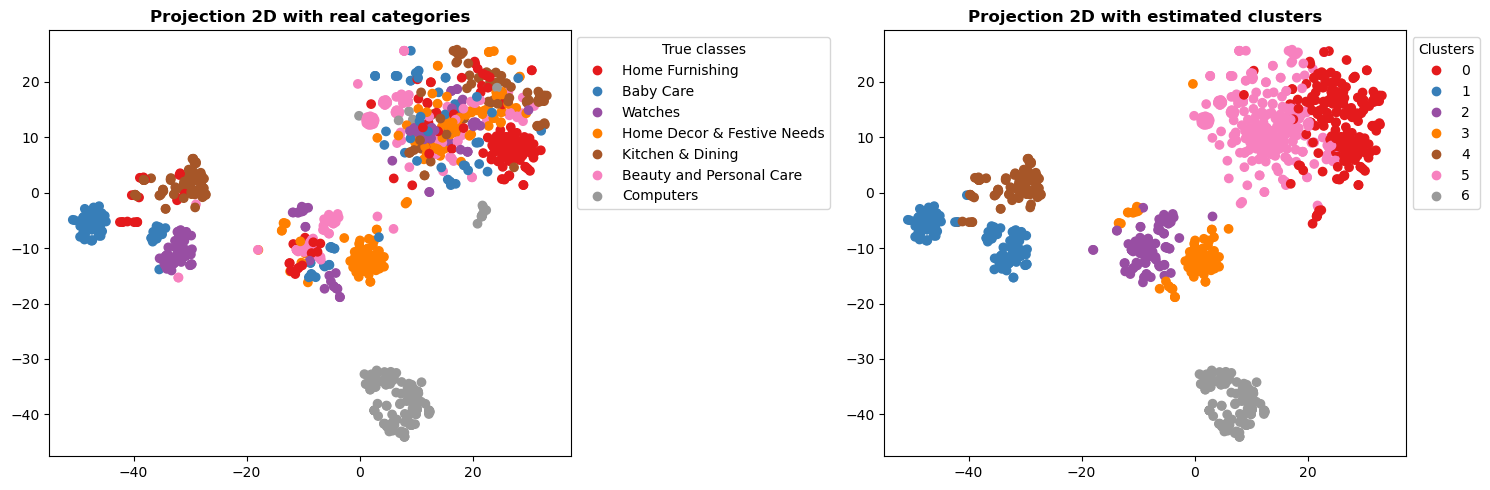

In [34]:
# Dimension reduction with T-SNE on word2vec data
tsne_word2vec = TSNE(n_components=2,perplexity=50,max_iter=2000,learning_rate=200, init="random",random_state=42)
X_word2vec_tsne = tsne_word2vec.fit_transform(X_word2vec)

# word2vec labels and clusters clusters
y_true_word2vec = X_word2vec_data["labels_encoded"]
y_pred_word2vec = kmeans_word2vec_labels_transform
# Tsne 2D for word2vec data
Tsne_2D(X_word2vec_tsne,y_true_word2vec,y_pred_word2vec)

- L'approche Word2vec donne des clusters relativement bien séparés avec un temps d'éxecution très rapide de la vectorisation(0.11 secondes).
- Le score ARI obtenu est de 0.278.

### II.1.d. Analyse par classes

In [35]:
word2vec_conf_mat = confusion_matrix(X_word2vec_data["labels_encoded"], kmeans_word2vec_labels_transform)
print(word2vec_conf_mat)
print()
print(classification_report(X_word2vec_data["labels_encoded"], kmeans_word2vec_labels_transform))

[[ 83   3  14   0  17  33   0]
 [ 12  80  20   1   0  37   0]
 [ 11  68   6  20   0  45   0]
 [ 30   0   9  67   0  44   0]
 [ 50   0   0   0  74  26   0]
 [ 16   2  48   2   1  81   0]
 [  9   0   0   0   0   6 135]]

              precision    recall  f1-score   support

           0       0.39      0.55      0.46       150
           1       0.52      0.53      0.53       150
           2       0.06      0.04      0.05       150
           3       0.74      0.45      0.56       150
           4       0.80      0.49      0.61       150
           5       0.30      0.54      0.38       150
           6       1.00      0.90      0.95       150

    accuracy                           0.50      1050
   macro avg       0.55      0.50      0.51      1050
weighted avg       0.55      0.50      0.51      1050



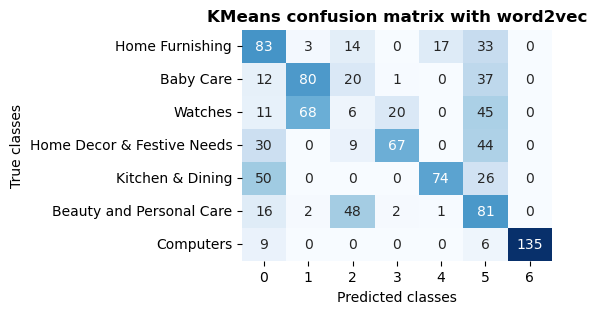

In [36]:
df_cm_word2vec = pd.DataFrame(word2vec_conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_word2vec, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with word2vec",fontweight="bold")
plt.show()

## II.2. Approche Universal Sentence Encoder (USE)

L'encodeur de phrase universel encode le texte en vecteurs de grande dimension qui peuvent être utilisés pour la classification de texte, la similitude sémantique, le regroupement et d'autres tâches en langage naturel. Le modèle pré-formé est disponible publiquement dans Tensorflow-hub. Il est livré avec deux variantes, à savoir l'une formée avec l'encodeur Transformer et l'autre formée avec le Deep Averaging Network (DAN).

Au lieu de calculer la moyenne des incorporations de mots de chaque mot dans une phrase pour obtenir des incorporations de phrase, USE génère des incorporations pour la phrase sans autre calcul.

In [39]:
# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
embed

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x17753bc4440>

### II.2.a. Extraction des features

In [40]:
def feature_USE_function(sentences, b_size) :
    batch_size = b_size
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feature = embed(sentences[idx:idx+batch_size])
        if step==0 :
            features = feature
        else :
            features = np.concatenate((features,feature))
    return features

In [42]:
initial_time = time.time()
# Create embeddings to our dataset sentences
batch_size = 10
sentences = text_to_vectorize["processed_corpus"].to_list()
# Applying the USE vectorization function to the dataset
X_USE = feature_USE_function(sentences, batch_size)
X_USE = pd.DataFrame(X_USE)
X_USE_data = pd.concat([X_USE, text_to_vectorize], axis=1)
duration_use=time.time()-initial_time
print("temps de USE : ", "%15.2f" % duration_use, "secondes")
X_USE_data

temps de USE :            16.46 secondes


,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,processed_corpus,labels,labels_encoded
0,-0.000236,0.044403,-0.002891,-0.039110,-0.020524,0.048848,-0.011327,0.035543,-0.001763,-0.005508,...,0.013982,-0.089072,-0.051330,-0.035898,0.009691,-0.027505,-0.062200,key feature elegance polyester multicolor abst...,Home Furnishing,4
1,0.032016,0.078298,-0.073354,0.011478,-0.010716,0.073059,0.035020,0.045511,0.001002,-0.014264,...,0.007364,-0.096227,-0.020332,-0.084628,-0.034075,0.017236,-0.070825,specification sathiyas cotton bath towel bath ...,Baby Care,0
2,-0.058010,0.075368,0.004594,0.006967,0.013254,0.095443,0.048597,0.014802,0.036734,0.032568,...,-0.008440,-0.072248,-0.039734,-0.051065,-0.023031,-0.007873,-0.082322,key feature eurospa cotton terry face towel se...,Baby Care,0
3,-0.000609,0.039776,-0.054012,0.081004,-0.035555,0.044328,0.031740,0.029080,0.043363,0.005610,...,0.000446,-0.086420,0.038111,-0.052355,-0.016037,0.021491,-0.060850,key feature santosh royal fashion cotton print...,Home Furnishing,4
4,0.060890,0.058278,-0.085874,0.056325,-0.019625,0.096856,-0.032961,-0.017611,-0.012290,-0.003125,...,-0.000026,-0.098188,0.052637,-0.032717,-0.062354,0.000601,-0.076110,key feature jaipur print cotton floral king si...,Home Furnishing,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.099937,-0.068015,0.026863,0.015257,-0.003116,0.055100,-0.082330,-0.050006,-0.058740,-0.003577,...,-0.024941,-0.113414,-0.006093,-0.039650,-0.041859,0.038908,-0.003070,oren empower extra large self adhesive sticker...,Baby Care,0
1046,-0.052617,-0.066250,0.040509,0.038699,-0.035976,0.026686,0.003897,-0.047700,-0.065425,0.001742,...,0.004600,-0.107168,-0.029740,-0.074661,-0.027715,0.046068,-0.036712,wallmantra large vinyl sticker sticker pack pr...,Baby Care,0
1047,0.014302,0.025510,-0.029441,0.026650,-0.028546,-0.031439,-0.065467,-0.014611,0.000948,0.037224,...,-0.031460,-0.113892,-0.021501,-0.064564,-0.024144,0.015090,-0.007794,buy uberlyfe extra large pigmented polyvinyl f...,Baby Care,0
1048,0.026495,-0.066740,-0.002053,0.015658,-0.025937,-0.069047,-0.094350,-0.079411,0.009145,0.031001,...,-0.052613,-0.068595,-0.038829,-0.027527,-0.000208,0.036551,-0.049875,buy wallmantra medium vinyl sticker sticker on...,Baby Care,0


### II.2.b. Entraînement d'un modèle KMeans

In [43]:
# KMeans model on USE data
n_clusters = text_to_vectorize.labels.nunique()
kmeans_USE =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_USE.fit(X_USE)

KMeans(n_clusters=7, n_init=10, random_state=42)

### II.2.c. Score ARI et représentation T-SNE en 2D 

In [44]:
# confusion matrix for USE data
conf_mat_USE = confusion_matrix(X_USE_data["labels_encoded"],kmeans_USE.labels_) 
conf_mat_USE

array([[ 14,  89,   3,   0,   4,  22,  18],
       [ 21,   1,  80,   0,  11,  37,   0],
       [ 23,   0,  70,   0,   0,  57,   0],
       [ 76,   0,   0,   0,  44,  30,   0],
       [  0,   1,   0,   0,   0,  75,  74],
       [ 47,   0,   2,   0,  85,  15,   1],
       [  0,   0,   0, 148,   0,   2,   0]], dtype=int64)

In [45]:
np.argmax(conf_mat_USE, axis=0)

array([3, 0, 1, 6, 5, 4, 4], dtype=int64)

In [50]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [3, 0, 1, 6, 5, 2, 4]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels["y_pred"] = y_pred
    labels["y_pred_transform"] = labels["y_pred"].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_USE_labels_transform = conf_mat_transform(X_USE_data["labels_encoded"], kmeans_USE.labels_)

Correspondance des clusters :  [3, 0, 1, 6, 5, 2, 4]


Le score ARI de mesure de similarité est de : 0.37


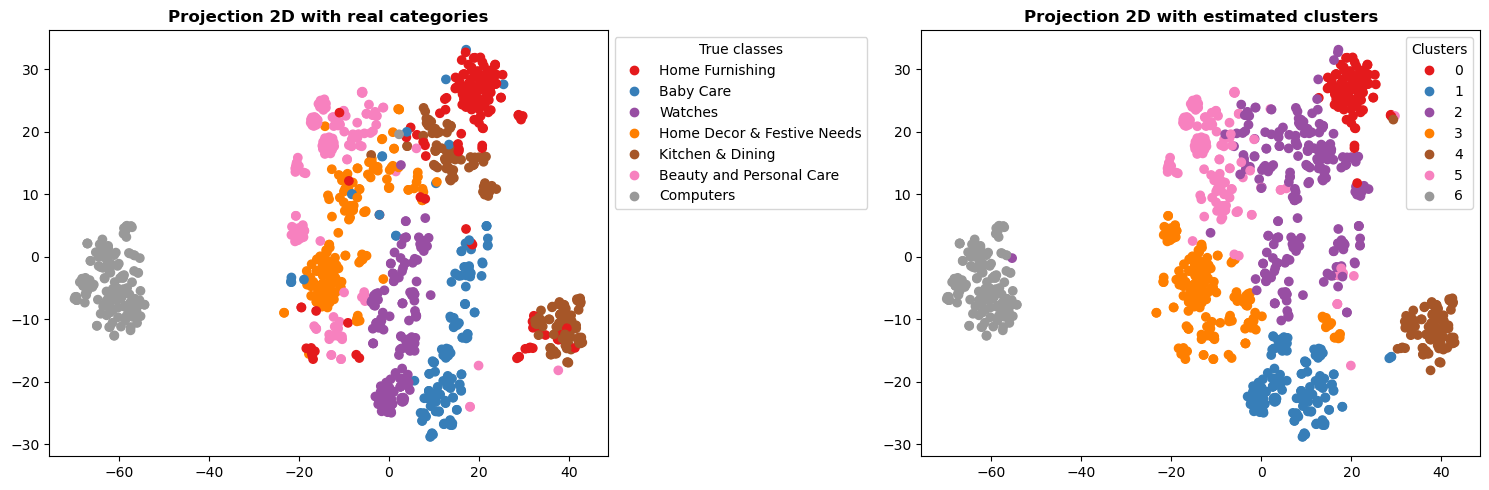

In [51]:
# Dimension reduction with T-SNE on USE data
tsne_USE = TSNE(n_components=2,perplexity=50,max_iter=2000,learning_rate=200, init="random",random_state=42)
X_USE_tsne = tsne_USE.fit_transform(X_USE)

# USE labels and clusters clusters
y_true_USE = X_USE_data["labels_encoded"]
y_pred_USE = kmeans_USE_labels_transform

# Tsne 2D for USE data
Tsne_2D(X_USE_tsne,y_true_USE,y_pred_USE)

### II.2.d. Analyse par classes

In [52]:
USE_conf_mat = confusion_matrix(X_USE_data["labels_encoded"], kmeans_USE_labels_transform)
print(USE_conf_mat)
print()
print(classification_report(X_USE_data["labels_encoded"], kmeans_USE_labels_transform))

[[ 89   3  22  14  18   4   0]
 [  1  80  37  21   0  11   0]
 [  0  70  57  23   0   0   0]
 [  0   0  30  76   0  44   0]
 [  1   0  75   0  74   0   0]
 [  0   2  15  47   1  85   0]
 [  0   0   2   0   0   0 148]]

              precision    recall  f1-score   support

           0       0.98      0.59      0.74       150
           1       0.52      0.53      0.52       150
           2       0.24      0.38      0.29       150
           3       0.42      0.51      0.46       150
           4       0.80      0.49      0.61       150
           5       0.59      0.57      0.58       150
           6       1.00      0.99      0.99       150

    accuracy                           0.58      1050
   macro avg       0.65      0.58      0.60      1050
weighted avg       0.65      0.58      0.60      1050



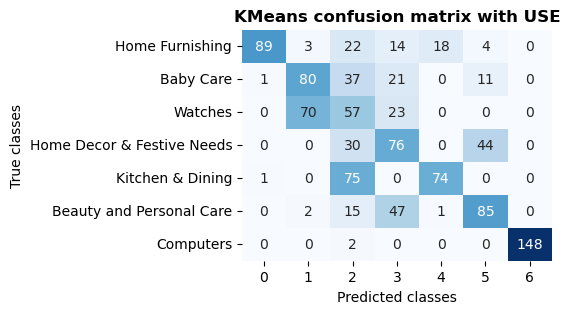

In [53]:
df_cm_USE = pd.DataFrame(USE_conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_USE, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with USE",fontweight="bold")
plt.show()

- Les résultats obtenus avec USE sont assez bons avec un temps d'éxecution très rapide égalemenht et un score ARI(0.37) qui est amélioré par rapport à la méthode Word2Vec.

## II.3. Approche BERT

**BERT : Représentations d'encodeurs bidirectionnels à partir de transformateurs**

BERT est un modèle d'apprentissage profond qui a donné des résultats de pointe sur une grande variété de tâches de traitement du langage naturel. Il signifie Bidirectionnel Encoder Representations for Transformers. Il a été pré-entraîné sur Wikipédia et BookCorpus et nécessite un réglage fin spécifique à la tâche.

BERT étape par étape:
- Bidirectionnel : BERT prend le passage de texte entier en entrée et lit le passage dans les deux sens pour comprendre le sens de chaque mot.
- Transformers : BERT est basé sur un réseau de Transformer profonds. Le réseau de Transformer est un type de réseau qui peut traiter efficacement de longs textes en utilisant l'attention. Une attention est un mécanisme permettant d'apprendre les relations contextuelles entre les mots d'un texte.
- Encoder Representations : à l'origine, Transformer comprend deux mécanismes distincts : un encodeur qui lit l'entrée de texte et un décodeur qui produit une prédiction pour la tâche. Puisque l'objectif de BERT est de générer un modèle de langage, seul le mécanisme d'encodeur est nécessaire, d'où le terme << Encoder Representation >>.

### II.3.a. Extraction des features

In [18]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Tokenize and encode text
def encode_text(text):
    inputs = tokenizer(text,return_tensors="pt",padding=True,truncation=True,add_special_tokens=True,max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract embeddings from BERT's output
    word_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling over tokens
    return word_embeddings

- Le texte est tokenisé et transformé en entrée pour BERT.
- BERT encode le texte et produit des embeddings pour chaque token.
- On prend la moyenne des embeddings pour avoir un seul vecteur représentant toute la phrase. Le modèle génère des embeddings contextuelles pour chaque phrase.
- Le vecteur est renvoyé pour être utilisé dans des tâches NLP comme la classification ou la recherche sémantique.

In [19]:
initial_time = time.time()

# Apply encoding to the corpus column to get BERT embedings
X_bert = np.vstack(text_to_vectorize["processed_corpus"].apply(encode_text))

duration_bert=time.time()-initial_time
print("temps de BERT : ", "%15.2f" % duration_bert, "secondes")
X_bert

temps de BERT :            93.62 secondes


array([[-0.0712169 ,  0.01452762,  0.78822166, ...,  0.05225255,
        -0.07440402, -0.05089309],
       [ 0.18754864, -0.04453689,  0.5080513 , ..., -0.13065654,
        -0.12078702,  0.16167289],
       [ 0.07268905,  0.00203779,  0.58957267, ..., -0.18347806,
        -0.23655663,  0.05071451],
       ...,
       [ 0.22338206, -0.05358668,  0.45580825, ...,  0.05280394,
        -0.03296794, -0.13138938],
       [ 0.1993737 , -0.05437279,  0.4286923 , ...,  0.26783514,
        -0.10092084, -0.4239158 ],
       [ 0.37041217, -0.20192121,  0.6117072 , ...,  0.19909188,
        -0.02239963, -0.18754485]], dtype=float32)

In [20]:
X_bert = pd.DataFrame(X_bert)
X_bert_data = pd.concat([X_bert, text_to_vectorize], axis=1)
X_bert_data

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,processed_corpus,labels,labels_encoded
0,-0.071217,0.014528,0.788222,-0.095934,0.349414,0.038125,0.114470,0.038890,-0.094383,-0.318038,...,0.130209,0.054015,0.083333,-0.387045,0.052253,-0.074404,-0.050893,key feature elegance polyester multicolor abst...,Home Furnishing,4
1,0.187549,-0.044537,0.508051,0.061791,0.228007,0.001809,0.173739,-0.064462,-0.008010,-0.178264,...,-0.065343,0.161342,0.174500,-0.397890,-0.130657,-0.120787,0.161673,specification sathiyas cotton bath towel bath ...,Baby Care,0
2,0.072689,0.002038,0.589573,-0.053331,0.289288,-0.006346,-0.151710,0.154893,-0.043866,-0.185085,...,0.111940,0.166227,0.205255,-0.396673,-0.183478,-0.236557,0.050715,key feature eurospa cotton terry face towel se...,Baby Care,0
3,0.114416,-0.043887,0.789521,-0.010880,0.257242,-0.198328,-0.018429,0.165563,-0.031426,0.079555,...,-0.117105,0.142889,0.041786,-0.427296,-0.007519,0.049825,-0.045136,key feature santosh royal fashion cotton print...,Home Furnishing,4
4,0.152932,0.041758,0.676307,-0.080821,0.232412,-0.120629,-0.073582,0.229989,0.043077,-0.122283,...,-0.022456,0.016971,0.171254,-0.569322,0.106811,0.024959,-0.101911,key feature jaipur print cotton floral king si...,Home Furnishing,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.172886,0.090343,0.417712,-0.191884,0.513945,-0.273728,0.028044,0.229859,0.051980,-0.085081,...,0.224807,0.158756,-0.071277,-0.631997,0.051438,-0.044015,0.113051,oren empower extra large self adhesive sticker...,Baby Care,0
1046,-0.408007,0.082386,0.576725,-0.063069,0.407291,-0.338766,0.069629,0.213620,0.308038,-0.190399,...,0.155214,0.012642,-0.145695,-0.496450,0.013863,-0.056844,-0.192802,wallmantra large vinyl sticker sticker pack pr...,Baby Care,0
1047,0.223382,-0.053587,0.455808,0.147175,0.394319,-0.224946,-0.167176,0.553789,-0.076325,0.031882,...,0.022785,0.080528,0.015468,-0.448760,0.052804,-0.032968,-0.131389,buy uberlyfe extra large pigmented polyvinyl f...,Baby Care,0
1048,0.199374,-0.054373,0.428692,0.090906,0.344739,-0.240115,0.072272,0.322541,0.126121,-0.214624,...,-0.106969,0.052080,-0.064746,-0.510436,0.267835,-0.100921,-0.423916,buy wallmantra medium vinyl sticker sticker on...,Baby Care,0


### II.3.b. Entraînement d'un modèle KMeans

In [21]:
# KMeans model on bert data
n_clusters = text_to_vectorize.labels.nunique()
kmeans_bert =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_bert.fit(X_bert)

KMeans(n_clusters=7, n_init=10, random_state=42)

### II.3.c. Score ARI et représentation T-SNE en 2D  

In [22]:
# confusion matrix for bert data
conf_mat_bert = confusion_matrix(X_bert_data["labels_encoded"],kmeans_bert.labels_) 
conf_mat_bert

array([[  9,   6,  15,  92,  14,   0,  14],
       [ 14,  80,   0,  13,  21,   0,  22],
       [ 19,  68,   0,   0,  23,   0,  40],
       [ 31,   1,   1,   1,  75,   0,  41],
       [ 19,   0,  74,  14,   0,   0,  43],
       [ 62,   3,   2,   1,  48,   0,  34],
       [  5,   0,   0,   7,   0, 134,   4]], dtype=int64)

In [23]:
np.argmax(conf_mat_bert, axis=0)

array([5, 1, 4, 0, 3, 6, 4], dtype=int64)

In [24]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    #corresp = np.argmax(conf_mat, axis=0)
    corresp = [5, 1, 4, 0, 3, 6, 2]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_bert_labels_transform = conf_mat_transform(X_bert_data["labels_encoded"], kmeans_bert.labels_)

Correspondance des clusters :  [5, 1, 4, 0, 3, 6, 2]


Le score ARI de mesure de similarité est de : 0.301


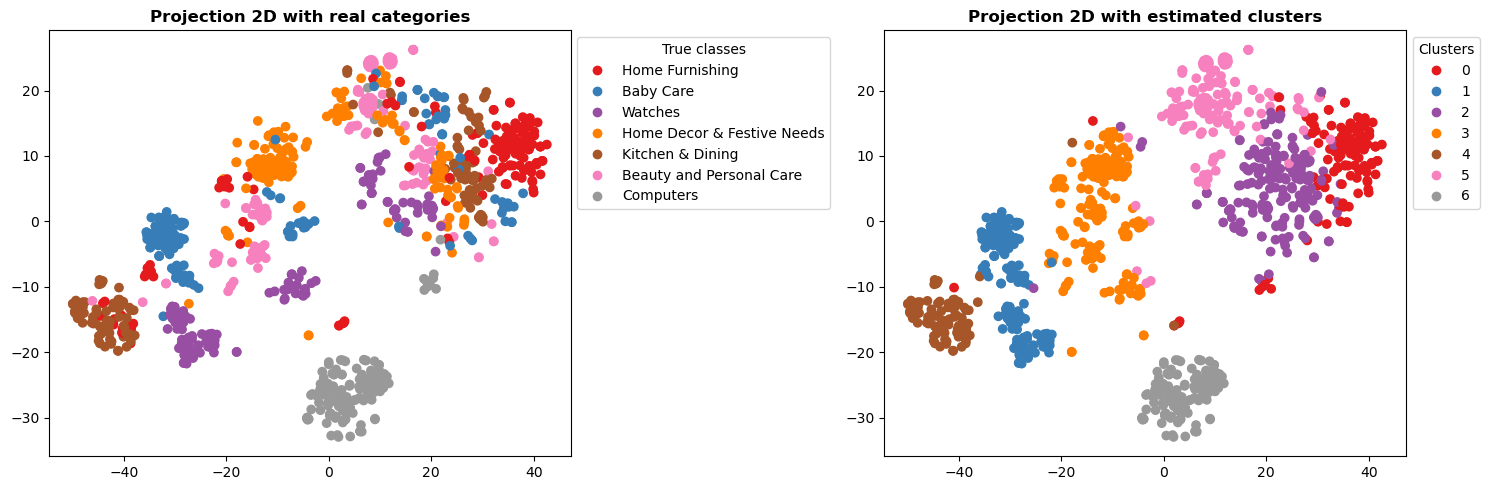

In [25]:
# Dimension reduction with T-SNE on bert data
tsne_bert = TSNE(n_components=2,perplexity=50,max_iter=2000,learning_rate=200, init="random",random_state=42)
X_bert_tsne = tsne_bert.fit_transform(X_bert)

# BERT labels and clusters clusters
y_true_bert = X_bert_data["labels_encoded"]
y_pred_bert = kmeans_bert_labels_transform

# Tsne 2D for BERT data
Tsne_2D(X_bert_tsne,y_true_bert,y_pred_bert)

### II.3.d. Analyse par classes

In [26]:
bert_conf_mat = confusion_matrix(X_bert_data["labels_encoded"], kmeans_bert_labels_transform)
print(bert_conf_mat)
print()
print(classification_report(X_bert_data["labels_encoded"], kmeans_bert_labels_transform))

[[ 92   6  14  14  15   9   0]
 [ 13  80  22  21   0  14   0]
 [  0  68  40  23   0  19   0]
 [  1   1  41  75   1  31   0]
 [ 14   0  43   0  74  19   0]
 [  1   3  34  48   2  62   0]
 [  7   0   4   0   0   5 134]]

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       150
           1       0.51      0.53      0.52       150
           2       0.20      0.27      0.23       150
           3       0.41      0.50      0.45       150
           4       0.80      0.49      0.61       150
           5       0.39      0.41      0.40       150
           6       1.00      0.89      0.94       150

    accuracy                           0.53      1050
   macro avg       0.58      0.53      0.55      1050
weighted avg       0.58      0.53      0.55      1050



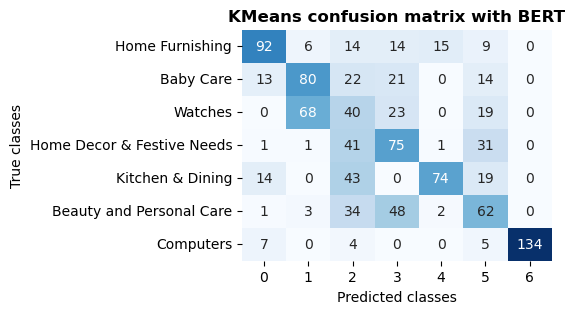

In [27]:
df_cm_bert = pd.DataFrame(bert_conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_bert, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with BERT",fontweight="bold")
plt.show()

- BERT donne des résultats assez solides mais avec un temps d'exécution un peu plus long que Word2Vec et USE.
- Son score ARI est également meilleur que celui de l'approche word2vec, bien qu'il reste un peu plus faible que celui de USE pour notre cas de figure. 

Dans ce qui suit, je présente l'état de l'art de l'approche DeBERTa, une variante de BERT, afin de comparer sa performance à celle de BERT sur les données dont on dispose. 

# 

## III. Etat de l'art : Approche DeBERTa

DeBERTa, introduit par Microsoft en 2020, apporte deux améliorations majeures par rapport à BERT :
- Disentangled Attention : Contrairement à BERT, qui utilise une unique représentation des mots, DeBERTa sépare les représentations de contenu et de position, permettant une meilleure modélisation des relations entre mots.
- Encodage des Positions Relatives : Plutôt que d'utiliser des embeddings de position absolus comme BERT, DeBERTa encode les relations entre tokens de manière plus contextuelle, ce qui améliore la compréhension des phrases longues et complexes.

Puisque le modèle DeBERTa n'a pas de model_max_length défini, je lui affecte initialement un max_length de 256(qui correspond à la moitié du max_length de BERT) que je tenterai d'optimiser par la suite.

In [28]:
# Charger le tokenizer et le modèle DeBERTa-large
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-large")
model = DebertaModel.from_pretrained("microsoft/deberta-large")

# Fonction pour encoder un texte avec DeBERTa-large
def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, add_special_tokens=True, max_length=256)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Moyenne des embeddings de tous les tokens
    word_embeddings = outputs.last_hidden_state.mean(dim=1)
    return word_embeddings.numpy()  # Convertir en NumPy pour l'empilement

In [29]:
# Appliquer l'encodage à la colonne 'processed_corpus' et mesurer le temps
initial_time = time.time()
X_deberta = np.vstack(text_to_vectorize["processed_corpus"].apply(encode_text))
duration_deberta = time.time() - initial_time

# Afficher le temps d'exécution
print("Temps de DeBERTa : ", "%15.2f" % duration_deberta, "secondes")
X_deberta

Temps de DeBERTa :           439.63 secondes


array([[-0.09116562, -0.08084687, -0.00264544, ..., -0.3137278 ,
        -0.03647459,  0.08162592],
       [-0.22903676,  0.06494429,  0.06875815, ..., -0.60327613,
        -0.1823781 , -0.00453295],
       [-0.07423721,  0.16201581,  0.09807142, ..., -0.46316466,
         0.07486068, -0.05374056],
       ...,
       [-0.04277581, -0.21330954,  0.23867244, ..., -0.18966283,
        -0.15592642, -0.00366496],
       [ 0.06150325, -0.3247631 ,  0.02277547, ..., -0.18526304,
         0.09216449,  0.0174736 ],
       [-0.22633584, -0.55548126,  0.21008769, ..., -0.1740431 ,
        -0.28237522, -0.16204767]], dtype=float32)

In [30]:
print(f"Gain de temps avec DeBERTa : {duration_bert - duration_deberta:.2f} secondes")

Gain de temps avec DeBERTa : -358.67 secondes


In [31]:
X_deberta = pd.DataFrame(X_deberta)
X_deberta_df = pd.concat([X_deberta, text_to_vectorize], axis=1)
X_deberta_df

,0,1,2,3,4,5,6,7,8,9,...,1017,1018,1019,1020,1021,1022,1023,processed_corpus,labels,labels_encoded
0,-0.091166,-0.080847,-0.002645,0.651722,-0.510610,0.585956,0.781671,0.193466,-0.180206,0.811620,...,0.353820,-0.265695,-0.168390,-0.590602,-0.313728,-0.036475,0.081626,key feature elegance polyester multicolor abst...,Home Furnishing,4
1,-0.229037,0.064944,0.068758,0.576624,-0.422606,0.554782,0.657517,0.004858,-0.092855,0.295152,...,-0.098723,-0.311024,0.010916,-0.435691,-0.603276,-0.182378,-0.004533,specification sathiyas cotton bath towel bath ...,Baby Care,0
2,-0.074237,0.162016,0.098071,0.675008,-0.304511,0.477918,0.614146,0.117701,-0.342463,0.371647,...,0.027055,-0.184966,-0.095890,-0.567867,-0.463165,0.074861,-0.053741,key feature eurospa cotton terry face towel se...,Baby Care,0
3,-0.111107,-0.015336,0.020306,0.555090,-0.425802,0.451849,0.797334,0.235736,-0.150989,0.393779,...,0.128661,0.062890,-0.012892,-0.807768,-0.474363,0.314297,0.070797,key feature santosh royal fashion cotton print...,Home Furnishing,4
4,-0.166819,0.042774,0.043573,0.469155,-0.448739,0.616456,0.756790,0.038963,-0.285300,0.478337,...,-0.000626,-0.054409,-0.103779,-0.555272,-0.341705,0.183615,-0.070048,key feature jaipur print cotton floral king si...,Home Furnishing,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.157579,-0.433590,-0.047453,0.535415,-0.599423,1.026582,1.141469,0.199872,0.188034,0.340953,...,0.379024,0.048411,-0.101957,-0.515039,-0.358410,0.292518,0.154749,oren empower extra large self adhesive sticker...,Baby Care,0
1046,-0.022313,-0.267144,-0.047922,0.330164,-0.589420,0.837026,0.824619,0.028916,0.007374,0.553353,...,0.130959,-0.214163,-0.113421,-0.305485,-0.505965,0.242679,-0.069617,wallmantra large vinyl sticker sticker pack pr...,Baby Care,0
1047,-0.042776,-0.213310,0.238672,0.139442,-0.230457,0.610264,0.574156,-0.689664,-0.122069,0.415729,...,0.462405,-0.137300,0.214160,-0.226646,-0.189663,-0.155926,-0.003665,buy uberlyfe extra large pigmented polyvinyl f...,Baby Care,0
1048,0.061503,-0.324763,0.022775,0.142591,-0.287649,0.947105,0.700795,-0.469699,-0.120449,0.363074,...,0.263807,0.021856,0.198273,-0.243755,-0.185263,0.092164,0.017474,buy wallmantra medium vinyl sticker sticker on...,Baby Care,0


In [32]:
# KMeans model on deberta data
n_clusters = text_to_vectorize.labels.nunique()
kmeans_deberta =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_deberta.fit(X_deberta)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [33]:
# confusion matrix for deberta data
conf_mat_deberta = confusion_matrix(X_deberta_df["labels_encoded"],kmeans_deberta.labels_) 
conf_mat_deberta

array([[ 14,   5,  85,   2,   9,  17,  18],
       [ 21,  80,   4,   0,  10,  35,   0],
       [ 27,  68,   0,   0,  15,  40,   0],
       [ 79,   1,   0,   0,  27,  43,   0],
       [  0,   0,  15,   0,  20,  40,  75],
       [ 49,   3,   0,   0,  59,  38,   1],
       [  0,   0,  10, 134,   5,   1,   0]], dtype=int64)

In [34]:
np.argmax(conf_mat_deberta, axis=0)

array([3, 1, 0, 6, 5, 3, 4], dtype=int64)

In [35]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = [3, 1, 0, 6, 5, 2, 4]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels["y_pred"] = y_pred
    labels["y_pred_transform"] = labels["y_pred"].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_deberta_labels_transform = conf_mat_transform(X_deberta_df["labels_encoded"], kmeans_deberta.labels_)

Correspondance des clusters :  [3, 1, 0, 6, 5, 2, 4]


Le score ARI de mesure de similarité est de : 0.296


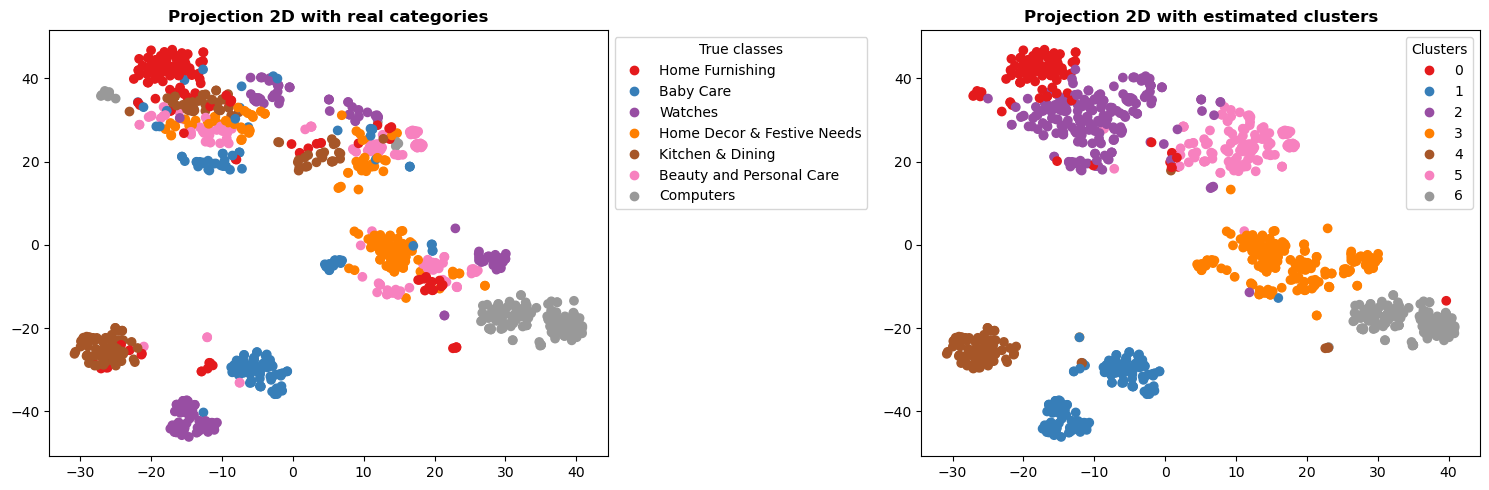

In [36]:
# Dimension reduction with T-SNE on deberta data
tsne_deberta = TSNE(n_components=2,perplexity=50,max_iter=2000,learning_rate=200, init="random",random_state=42)
X_deberta_tsne = tsne_deberta.fit_transform(X_deberta)

# USE labels and clusters clusters
y_true_deberta = X_deberta_df["labels_encoded"]
y_pred_deberta = kmeans_deberta_labels_transform

# Tsne 2D for deberta data
Tsne_2D(X_deberta_tsne,y_true_deberta,y_pred_deberta)

In [37]:
deberta_conf_mat = confusion_matrix(X_deberta_df["labels_encoded"], kmeans_deberta_labels_transform)
print(deberta_conf_mat)
print()
print(classification_report(X_deberta_df["labels_encoded"], kmeans_deberta_labels_transform))

[[ 85   5  17  14  18   9   2]
 [  4  80  35  21   0  10   0]
 [  0  68  40  27   0  15   0]
 [  0   1  43  79   0  27   0]
 [ 15   0  40   0  75  20   0]
 [  0   3  38  49   1  59   0]
 [ 10   0   1   0   0   5 134]]

              precision    recall  f1-score   support

           0       0.75      0.57      0.64       150
           1       0.51      0.53      0.52       150
           2       0.19      0.27      0.22       150
           3       0.42      0.53      0.46       150
           4       0.80      0.50      0.61       150
           5       0.41      0.39      0.40       150
           6       0.99      0.89      0.94       150

    accuracy                           0.53      1050
   macro avg       0.58      0.53      0.54      1050
weighted avg       0.58      0.53      0.54      1050



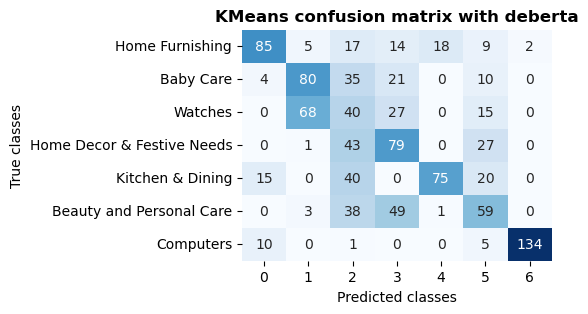

In [38]:
df_cm_deberta = pd.DataFrame(deberta_conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_deberta, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with deberta",fontweight="bold")
plt.show()

- L'approche DeBERTa-large met beacoup plus de temps à s'exécuter pour notre cas de figure et n'améliore malheureusement pas les performances par rapport à BERT. Son score ARI(0.296) est également inférieur à celui obtenue avec BERT(0.301) bien qu'il reste assez bon comparé à Word2Vec par exemple.

## Démarche d'optimisation du modèle DeBERTa

- Je vais tenter d'optimiser la valeur de max_length puis ré-entrainer le modèle DeBERTa large pour voir si ça améliore les resultats tout en restant dans un temps de calcul raisonnable.

In [39]:
# Details of the DeBERTa-large tokenizer
tokenizer

DebertaTokenizer(name_or_path='microsoft/deberta-large', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50264: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}
)

### Distribution des longueurs des séquences

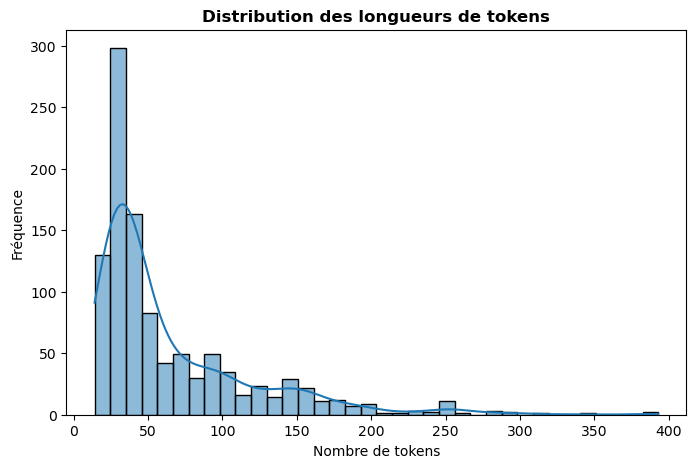

In [40]:
# Appliquer la tokenisation et récupérer la longueur des séquences
df = text_to_vectorize.copy()
df["token_length"] = df["processed_corpus"].apply(lambda x: len(tokenizer(x)["input_ids"]))

# Visualiser la distribution des longueurs de tokens
plt.figure(figsize=(8,5))
sns.histplot(df["token_length"],kde=True)
plt.xlabel("Nombre de tokens")
plt.ylabel("Fréquence")
plt.title("Distribution des longueurs de tokens",fontweight="bold")
plt.show()

In [41]:
# Tokens lengths description
display(df["token_length"].describe())
print()
print("-"*50)
print()
# Optimal max_length
percentile_95 = df["token_length"].quantile(0.95)
display(f"95e percentile : {percentile_95:.0f}")

count    1050.000000
mean       64.605714
std        54.746532
min        14.000000
25%        29.000000
50%        41.000000
75%        83.750000
max       393.000000
Name: token_length, dtype: float64


--------------------------------------------------



'95e percentile : 174'

- Le 95e percentile permet d'estimer la longueur qui couvre 95% des cas sans tronquer trop d'exemples.

### Ré-entrainement du modèle avec max_lengths=percentile_95

In [18]:
# Charger le tokenizer et le modèle DeBERTa-base
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-large")
model = DebertaModel.from_pretrained("microsoft/deberta-large")

# Fonction pour encoder un texte avec différents max_length
def encode_text(text):
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        add_special_tokens=True, 
        max_length=174
    )

    with torch.no_grad():
        outputs = model(**inputs)

    # Moyenne des embeddings de tous les tokens
    word_embeddings = outputs.last_hidden_state.mean(dim=1)
    return word_embeddings.numpy()  # Convertir en NumPy pour l'empilement

In [19]:
# Appliquer l'encodage à la colonne 'processed_corpus' et mesurer le temps
initial_time = time.time()
X_deberta = np.vstack(text_to_vectorize["processed_corpus"].apply(encode_text))
duration_deberta = time.time() - initial_time

# Afficher le temps d'exécution
print("Temps de DeBERTa : ", "%15.2f" % duration_deberta, "secondes")
X_deberta

Temps de DeBERTa :           462.00 secondes


array([[-0.07907001, -0.07497742, -0.01682116, ..., -0.3120309 ,
        -0.0883664 ,  0.04814148],
       [-0.22903676,  0.06494429,  0.06875815, ..., -0.60327613,
        -0.1823781 , -0.00453295],
       [-0.07423721,  0.16201581,  0.09807142, ..., -0.46316466,
         0.07486068, -0.05374056],
       ...,
       [-0.04277581, -0.21330954,  0.23867244, ..., -0.18966283,
        -0.15592642, -0.00366496],
       [ 0.06150325, -0.3247631 ,  0.02277547, ..., -0.18526304,
         0.09216449,  0.0174736 ],
       [-0.22633584, -0.55548126,  0.21008769, ..., -0.1740431 ,
        -0.28237522, -0.16204767]], dtype=float32)

In [20]:
X_deberta = pd.DataFrame(X_deberta)
X_deberta_df = pd.concat([X_deberta, text_to_vectorize], axis=1)
X_deberta_df

,0,1,2,3,4,5,6,7,8,9,...,1017,1018,1019,1020,1021,1022,1023,processed_corpus,labels,labels_encoded
0,-0.079070,-0.074977,-0.016821,0.613574,-0.509014,0.512149,0.789437,0.216319,-0.225252,0.750223,...,0.356444,-0.246112,-0.193745,-0.603458,-0.312031,-0.088366,0.048141,key feature elegance polyester multicolor abst...,Home Furnishing,4
1,-0.229037,0.064944,0.068758,0.576624,-0.422606,0.554782,0.657517,0.004858,-0.092855,0.295152,...,-0.098723,-0.311024,0.010916,-0.435691,-0.603276,-0.182378,-0.004533,specification sathiyas cotton bath towel bath ...,Baby Care,0
2,-0.074237,0.162016,0.098071,0.675008,-0.304511,0.477918,0.614146,0.117701,-0.342463,0.371647,...,0.027055,-0.184966,-0.095890,-0.567867,-0.463165,0.074861,-0.053741,key feature eurospa cotton terry face towel se...,Baby Care,0
3,-0.111107,-0.015336,0.020306,0.555090,-0.425802,0.451849,0.797334,0.235736,-0.150989,0.393779,...,0.128661,0.062890,-0.012892,-0.807768,-0.474363,0.314297,0.070797,key feature santosh royal fashion cotton print...,Home Furnishing,4
4,-0.160484,0.037779,0.049617,0.473459,-0.451514,0.606459,0.762708,0.041808,-0.284512,0.516936,...,0.028787,-0.051676,-0.111383,-0.553043,-0.331239,0.208113,-0.078519,key feature jaipur print cotton floral king si...,Home Furnishing,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.105434,-0.304249,-0.118582,0.458273,-0.174216,0.811790,1.187762,0.253399,0.328617,0.300502,...,0.327312,-0.057027,-0.426812,-0.360268,-0.185840,0.207573,0.134341,oren empower extra large self adhesive sticker...,Baby Care,0
1046,0.004039,-0.219944,-0.063472,0.314829,-0.551863,0.749128,0.793835,-0.017631,-0.005856,0.515034,...,0.161946,-0.141629,-0.070152,-0.284105,-0.462151,0.196425,-0.064943,wallmantra large vinyl sticker sticker pack pr...,Baby Care,0
1047,-0.042776,-0.213310,0.238672,0.139442,-0.230457,0.610264,0.574156,-0.689664,-0.122069,0.415729,...,0.462405,-0.137300,0.214160,-0.226646,-0.189663,-0.155926,-0.003665,buy uberlyfe extra large pigmented polyvinyl f...,Baby Care,0
1048,0.061503,-0.324763,0.022775,0.142591,-0.287649,0.947105,0.700795,-0.469699,-0.120449,0.363074,...,0.263807,0.021856,0.198273,-0.243755,-0.185263,0.092164,0.017474,buy wallmantra medium vinyl sticker sticker on...,Baby Care,0


In [21]:
# KMeans model on deberta data
n_clusters = text_to_vectorize.labels.nunique()
kmeans_deberta =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_deberta.fit(X_deberta)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [22]:
# confusion matrix for deberta data
conf_mat_deberta = confusion_matrix(X_deberta_df["labels_encoded"],kmeans_deberta.labels_) 
conf_mat_deberta

array([[  2,   9,   5,  87,  18,  14,  15],
       [  0,  10,  80,   5,   0,  21,  34],
       [  0,  15,  68,   0,   0,  26,  41],
       [  0,  30,   1,   0,   0,  78,  41],
       [  0,  20,   0,  13,  75,   0,  42],
       [  0,  60,   3,   0,   1,  49,  37],
       [134,   5,   0,   7,   0,   0,   4]], dtype=int64)

In [23]:
np.argmax(conf_mat_deberta, axis=0)

array([6, 5, 1, 0, 4, 3, 4], dtype=int64)

In [24]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = [6, 5, 1, 0, 4, 3, 2]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels["y_pred"] = y_pred
    labels["y_pred_transform"] = labels["y_pred"].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_deberta_labels_transform = conf_mat_transform(X_deberta_df["labels_encoded"], kmeans_deberta.labels_)

Correspondance des clusters :  [6, 5, 1, 0, 4, 3, 2]


Le score ARI de mesure de similarité est de : 0.298


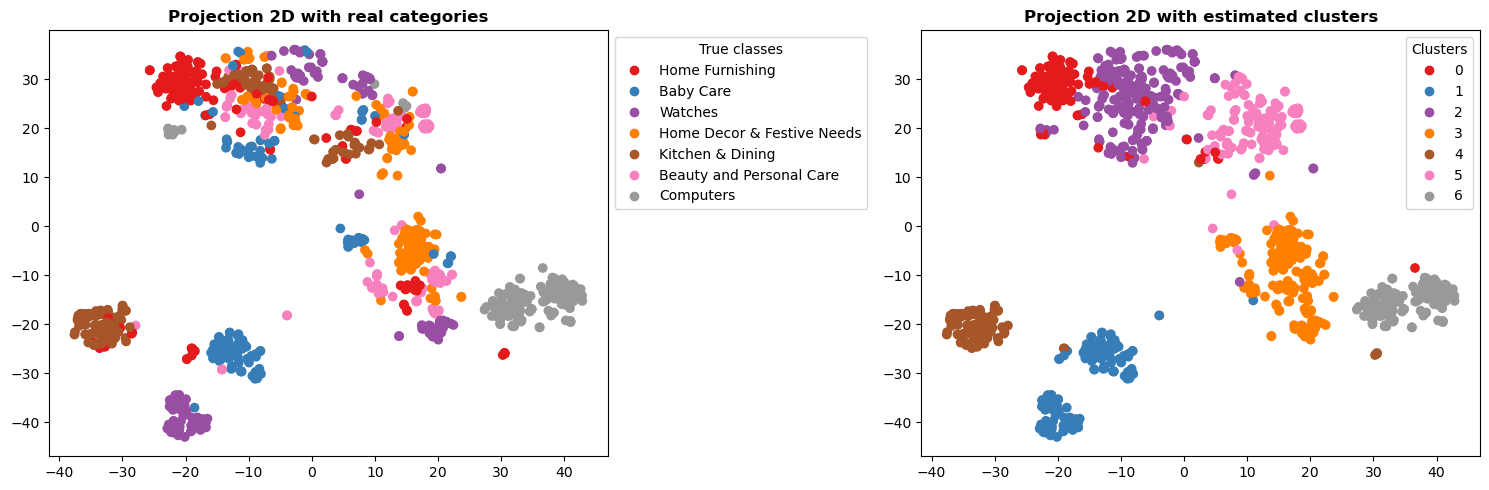

In [25]:
# Dimension reduction with T-SNE on deberta data
tsne_deberta = TSNE(n_components=2,perplexity=50,max_iter=2000,learning_rate=200, init="random",random_state=42)
X_deberta_tsne = tsne_deberta.fit_transform(X_deberta)

# USE labels and clusters clusters
y_true_deberta = X_deberta_df["labels_encoded"]
y_pred_deberta = kmeans_deberta_labels_transform

# Tsne 2D for deberta data
Tsne_2D(X_deberta_tsne,y_true_deberta,y_pred_deberta)

In [26]:
deberta_conf_mat = confusion_matrix(X_deberta_df["labels_encoded"], kmeans_deberta_labels_transform)
print(deberta_conf_mat)
print()
print(classification_report(X_deberta_df["labels_encoded"], kmeans_deberta_labels_transform))

[[ 87   5  15  14  18   9   2]
 [  5  80  34  21   0  10   0]
 [  0  68  41  26   0  15   0]
 [  0   1  41  78   0  30   0]
 [ 13   0  42   0  75  20   0]
 [  0   3  37  49   1  60   0]
 [  7   0   4   0   0   5 134]]

              precision    recall  f1-score   support

           0       0.78      0.58      0.66       150
           1       0.51      0.53      0.52       150
           2       0.19      0.27      0.23       150
           3       0.41      0.52      0.46       150
           4       0.80      0.50      0.61       150
           5       0.40      0.40      0.40       150
           6       0.99      0.89      0.94       150

    accuracy                           0.53      1050
   macro avg       0.58      0.53      0.55      1050
weighted avg       0.58      0.53      0.55      1050



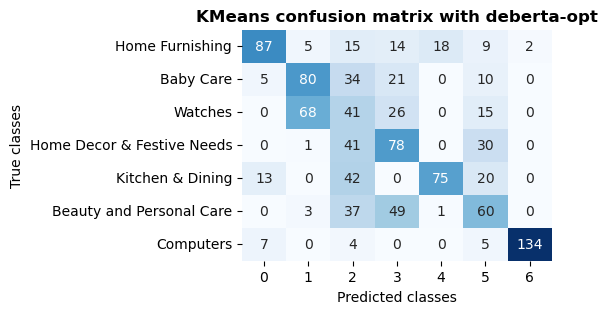

In [27]:
df_cm_deberta = pd.DataFrame(deberta_conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_deberta, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with deberta-opt",fontweight="bold")
plt.show()

- L'optimisation du max_length en l'ajustant au 95e percentile de la distribution des longueurs de séquences n'a pas permis de réduire le coût computationnel par rapport au DeBERTa sans optimisation, et n'a pas non plus permis de compenser la baisse de performance

## IV. Analyse de la feature importance globale avec  SHAP et locale avec LIME

- J'entraine un modèle de classification proxy, un RandomForestClassifier, basé sur les clusters obtenus avec KMeans puis j'analyse l'importance des features avec SHAP et LIME.

In [28]:
# KMeans labels
X_deberta_df["kmeans_labels"] = kmeans_deberta.labels_
X_deberta_df

,0,1,2,3,4,5,6,7,8,9,...,1018,1019,1020,1021,1022,1023,processed_corpus,labels,labels_encoded,kmeans_labels
0,-0.079070,-0.074977,-0.016821,0.613574,-0.509014,0.512149,0.789437,0.216319,-0.225252,0.750223,...,-0.246112,-0.193745,-0.603458,-0.312031,-0.088366,0.048141,key feature elegance polyester multicolor abst...,Home Furnishing,4,6
1,-0.229037,0.064944,0.068758,0.576624,-0.422606,0.554782,0.657517,0.004858,-0.092855,0.295152,...,-0.311024,0.010916,-0.435691,-0.603276,-0.182378,-0.004533,specification sathiyas cotton bath towel bath ...,Baby Care,0,3
2,-0.074237,0.162016,0.098071,0.675008,-0.304511,0.477918,0.614146,0.117701,-0.342463,0.371647,...,-0.184966,-0.095890,-0.567867,-0.463165,0.074861,-0.053741,key feature eurospa cotton terry face towel se...,Baby Care,0,6
3,-0.111107,-0.015336,0.020306,0.555090,-0.425802,0.451849,0.797334,0.235736,-0.150989,0.393779,...,0.062890,-0.012892,-0.807768,-0.474363,0.314297,0.070797,key feature santosh royal fashion cotton print...,Home Furnishing,4,6
4,-0.160484,0.037779,0.049617,0.473459,-0.451514,0.606459,0.762708,0.041808,-0.284512,0.516936,...,-0.051676,-0.111383,-0.553043,-0.331239,0.208113,-0.078519,key feature jaipur print cotton floral king si...,Home Furnishing,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.105434,-0.304249,-0.118582,0.458273,-0.174216,0.811790,1.187762,0.253399,0.328617,0.300502,...,-0.057027,-0.426812,-0.360268,-0.185840,0.207573,0.134341,oren empower extra large self adhesive sticker...,Baby Care,0,1
1046,0.004039,-0.219944,-0.063472,0.314829,-0.551863,0.749128,0.793835,-0.017631,-0.005856,0.515034,...,-0.141629,-0.070152,-0.284105,-0.462151,0.196425,-0.064943,wallmantra large vinyl sticker sticker pack pr...,Baby Care,0,1
1047,-0.042776,-0.213310,0.238672,0.139442,-0.230457,0.610264,0.574156,-0.689664,-0.122069,0.415729,...,-0.137300,0.214160,-0.226646,-0.189663,-0.155926,-0.003665,buy uberlyfe extra large pigmented polyvinyl f...,Baby Care,0,5
1048,0.061503,-0.324763,0.022775,0.142591,-0.287649,0.947105,0.700795,-0.469699,-0.120449,0.363074,...,0.021856,0.198273,-0.243755,-0.185263,0.092164,0.017474,buy wallmantra medium vinyl sticker sticker on...,Baby Care,0,5


In [29]:
y_kmeans=X_deberta_df.kmeans_labels
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_deberta, y_kmeans, 
                                                    test_size=0.3, random_state=42)

# Entraîner un RandomForest pour prédire les clusters
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Importance globale des variables avec SHAP 

In [30]:
# load JS visualization code to notebook
shap.initjs()

# Explication SHAP globale
explainer = shap.TreeExplainer(rf_model,X_train)
shap_values = explainer.shap_values(X_test)

 97%|=================== | 2130/2205 [00:12<00:00]       

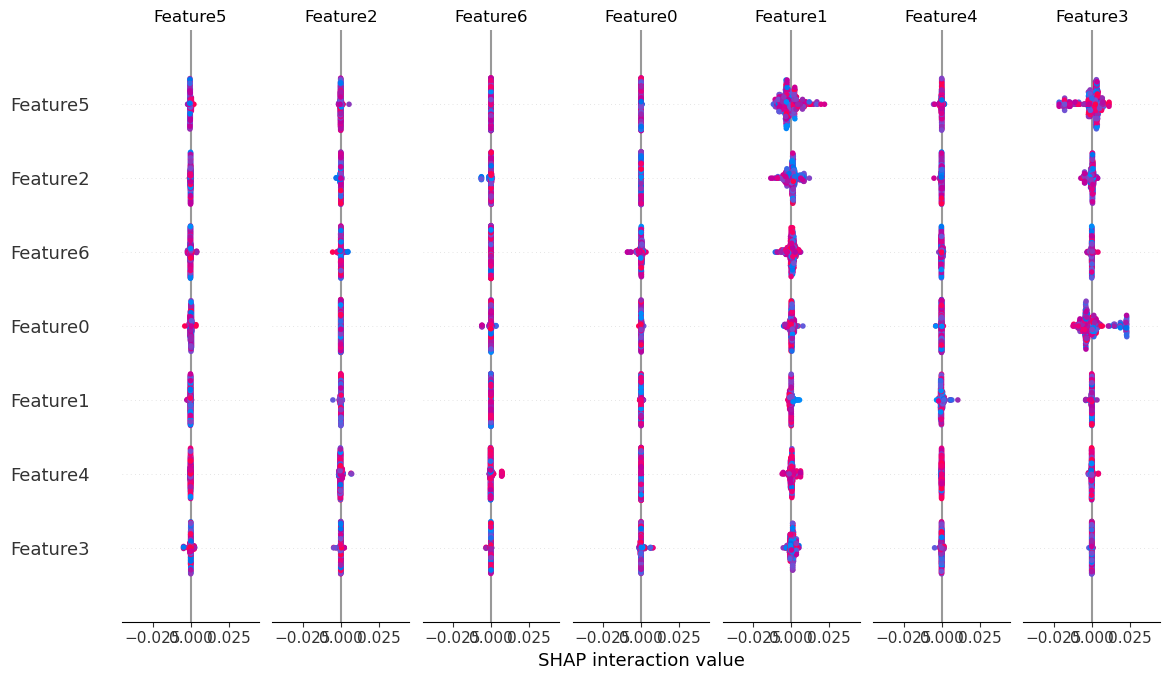

In [31]:
# Convertir les noms de colonnes en chaînes de caractères
feature_names = np.array([f"Feature{i}" for i in range(X_test.shape[1])])

# Visualisation SHAP avec les bons noms de features
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

- Dans ce cas de figure, il m'est difficile de dégager une analyse fiable de l'importance des features globale au vu des résultats obtenus avec SHAP

## Importance locale des variables avec LIME

In [34]:
# Fonction de prédiction pour KMeans : Inverser la distance aux centroids pour approximer une proba
def kmeans_predict_proba(X):
    distances = kmeans_deberta.transform(X)  # Distance aux centroides
    probas = np.exp(-distances)  # Exponentielle pour transformer les distances en pseudo-probas
    return probas / probas.sum(axis=1, keepdims=True)  # Normalisation

# Initialiser LIME
explainer = LimeTabularExplainer(
    training_data=X_deberta.values,  # Données d'entraînement
    feature_names=[f"Feature{i}" for i in range(X_deberta.shape[1])],  
    class_names=X_deberta_df["labels"].unique(),  # Class labels
    mode="classification"
)

In [35]:
# Choisir un texte à expliquer (ex: premier document)
idx = 0
sample = X_deberta.iloc[idx].values.reshape(1, -1)

# Générer une explication locale
exp = explainer.explain_instance(sample.flatten(), kmeans_predict_proba, num_features=10)

# Afficher les résultats
exp.show_in_notebook()

Ce graphique montre une prédiction locale pour un article donné, ainsi que les probabilités de classification. Il présente l'impacte local des caractéristiques sur la prédiction.
- Le modèle prédit avec une probabilité de 0.56 que l’article appartient à la catégorie "Computers".
- Lorsque Feature436 > 4.67, Feature804 > −2.94 et Feature672 > 1.09, il y a de fortes chance que cet article soit prédit dans le cluster "Computers".